In [122]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [12]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

pd.set_option("display.precision", 3)

# Left join pour ajouter la table des features et des stores
X = pd.merge(pd.merge(train, features, on=['Store', 'Date'], how='left'),stores,on=['Store'], how='left')

# Ajout de la date en multi index pour avoir l'annee et le mois
X['Date'] = pd.to_datetime(X['Date'])
X['Month'] = X['Date'].dt.month
X['Year'] = X['Date'].dt.year
X['Date'] = X['Date'].dt.date
X = X.set_index(['Year','Month','Date']).drop('IsHoliday_y',axis=1)

In [13]:
# Transformation des features categoriels
categorical_cols = ['IsHoliday_x','Type']
X = pd.get_dummies(X,columns=categorical_cols,drop_first=True)

# Imputing des valeurs manquantes
new_X = IterativeImputer(random_state=0).fit_transform(X)

# Transformation des arrays en DataFrames
new_X = pd.DataFrame(new_X,columns=X.columns)
new_X = new_X.set_index(X.index)

# Standardisation des features numeriques
numerical_features = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size','Weekly_Sales']
new_X[numerical_features] = StandardScaler().fit_transform(new_X[numerical_features])

# Reducion de la memoire utilisee
new_X = new_X.astype('float32')

Etude des distributions des features en 2 étapes

    - Etape 1 : Etude des moyennes des features par magasin (suppression des variables size et type)

    - Etape 2 : Etude de l'ensemble des features sur les ventes

Estimation de l'importance des features en utilisant un modèle Random Forest

Top 10 des meilleurs features:
        Feature  Importance
0          Dept       0.785
1     MarkDown3       0.075
2     MarkDown1       0.057
3     MarkDown2       0.021
4     MarkDown5       0.016
5   Temperature       0.013
6           CPI       0.010
7     MarkDown4       0.009
8    Fuel_Price       0.008
9  Unemployment       0.004


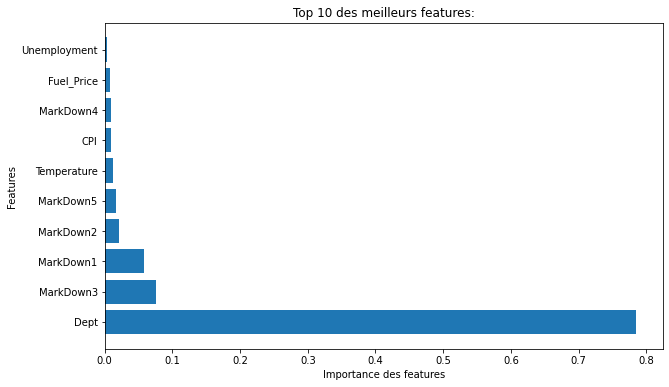

In [16]:
# Calcul de l'importance des features pour chaque magasin
df_importance = pd.DataFrame(columns=['Feature', 'Importance'])

for i in range(1,len(new_X['Store'].unique())+1):
    # Creation d'un dataset par magasin
    test1 = new_X[new_X['Store']==i].drop('Size',axis=1).drop('Store',axis=1).drop('Type_B',axis=1).drop('Type_C',axis=1)

    # Utilisation d'un modele RF pour estimer l'importances des features
    model = RandomForestRegressor(n_estimators=50, random_state=0,verbose=0,n_jobs=-1)
    model.fit(test1.drop('Weekly_Sales',axis=1), test1['Weekly_Sales'])

    feature_importances = model.feature_importances_
    fts = pd.DataFrame({'Feature': test1.drop('Weekly_Sales',axis=1).columns, 'Importance': feature_importances})

    if len(df_importance.index)==0:
        df_importance = fts
    else:
        df_importance = pd.concat([df_importance,fts],axis=0)

# Calcul de l'importance moyenne des features en groupant l'ensemble des magasins
feature_importance_df = df_importance.groupby('Feature').mean().sort_values('Importance', ascending=False).reset_index()

# Afficher les 10 meilleurs features
top_n = 10  
print(f'Top {top_n} des meilleurs features:')
print(feature_importance_df.head(top_n))

# Visualisation des 10 meilleurs features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Importance des features')
plt.ylabel('Features')
plt.title(f'Top {top_n} des meilleurs features:')
plt.show()

Visualisation de la correlation entre les features

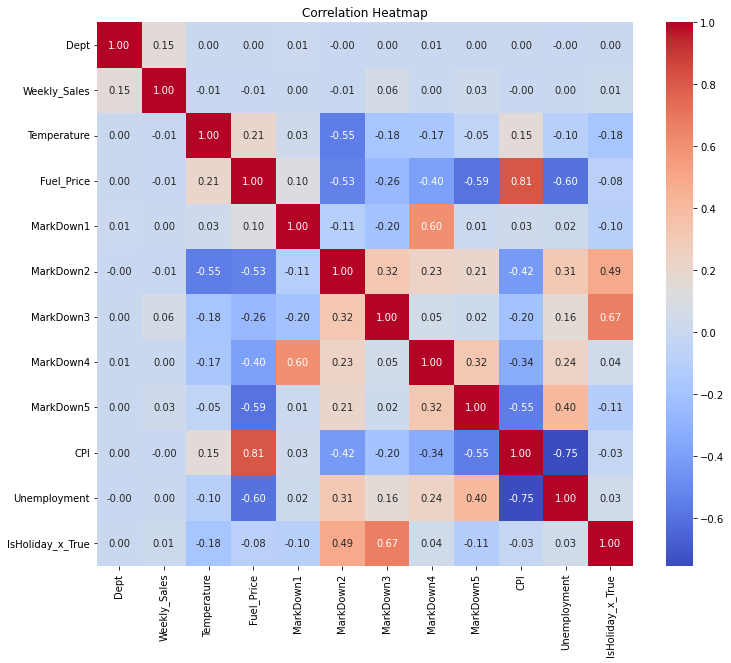

In [8]:
for i in range(1,len(new_X['Store'].unique())+1):
    # Creation d'un dataset par magasin
    test1 = new_X[new_X['Store']==i].drop('Size',axis=1).drop('Store',axis=1).drop('Type_B',axis=1).drop('Type_C',axis=1)
    correlation_matrix = test1.corr()
    
    if i == 1:
        correlation_matrix_mean = correlation_matrix
    else:
        correlation_matrix_mean = correlation_matrix_mean + correlation_matrix


# Creation d'une heatmap pour voir la matrice de correlation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_mean/45, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Mise en relief de l'impact des vacances sur les ventes

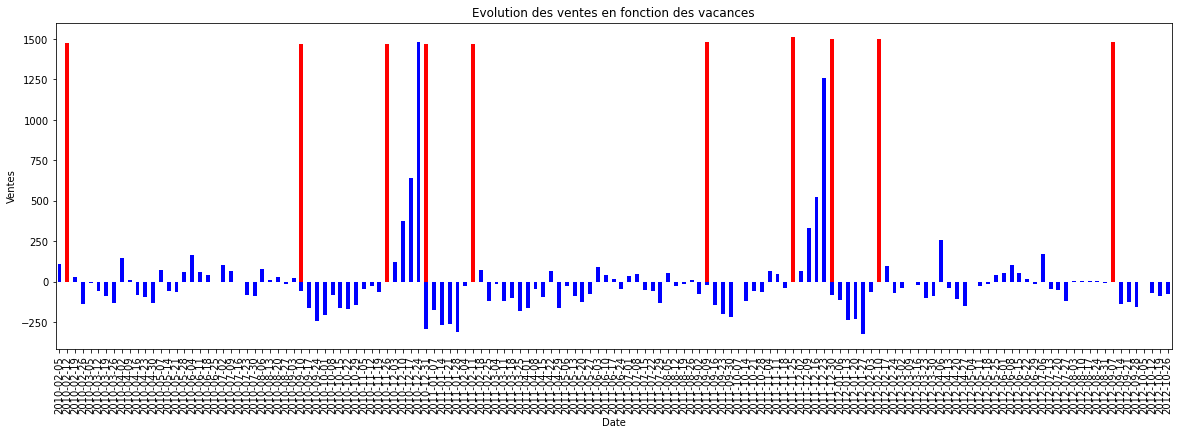

In [107]:
# On regroupe les ventes normalisees par date et on affiche sur le graphique a quelles dates se trouvent les vacances
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(20, 6), title='Evolution des ventes en fonction des vacances', color='blue',ylabel='Ventes')
(new_X['IsHoliday_x_True']/2).groupby('Date').sum().plot(kind='bar',figsize=(20, 6), color='red')
plt.show()

Mise en relief du prix de l'essence sur les ventes

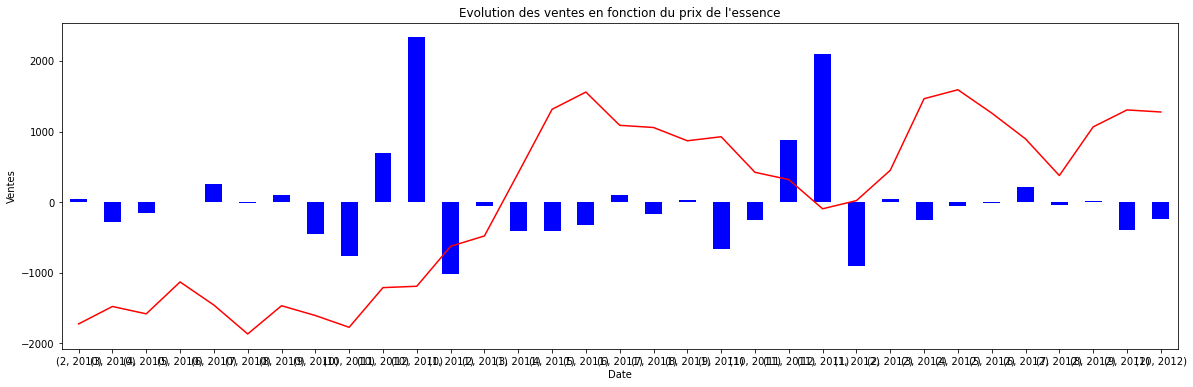

In [70]:
# On regroupe les ventes normalisees par mois et on affiche sur le graphique l'evolution du prix de l'essence
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 6), title="Evolution des ventes en fonction du prix de l'essence", color='blue',ylabel='Ventes')
(new_X['Fuel_Price']/10).groupby(['Month','Year'],sort=False).sum().plot(kind='line',figsize=(20, 6), color='red',xlabel='Date')
plt.show()

Mise en relief du pouvoir d'achat sur les ventes

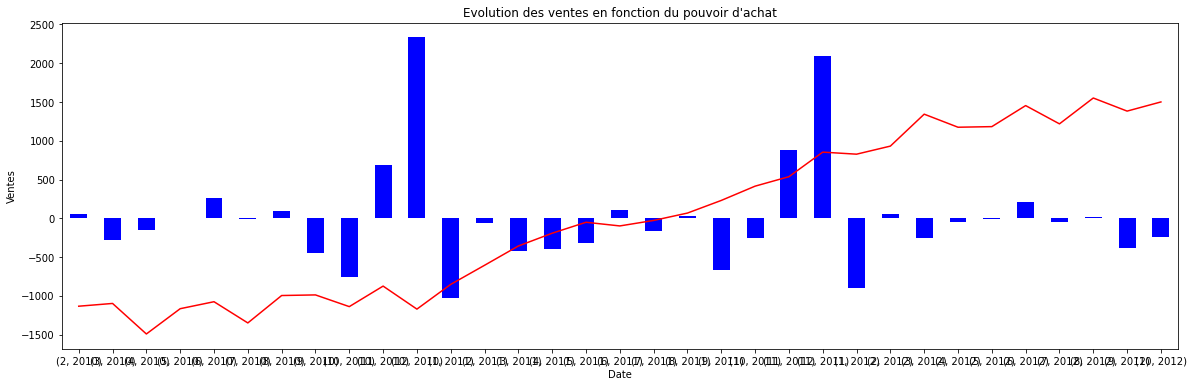

In [81]:
# On regroupe les ventes normalisees par mois et on affiche sur le graphique l'evolution du pouvoir d'achat
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 6), title="Evolution des ventes en fonction du pouvoir d'achat", color='blue',ylabel='Ventes')
new_X['CPI'].groupby(['Month','Year'],sort=False).sum().plot(kind='line',figsize=(20, 6), color='red', xlabel='Date')
plt.show()

Mise en relief de la température sur les ventes

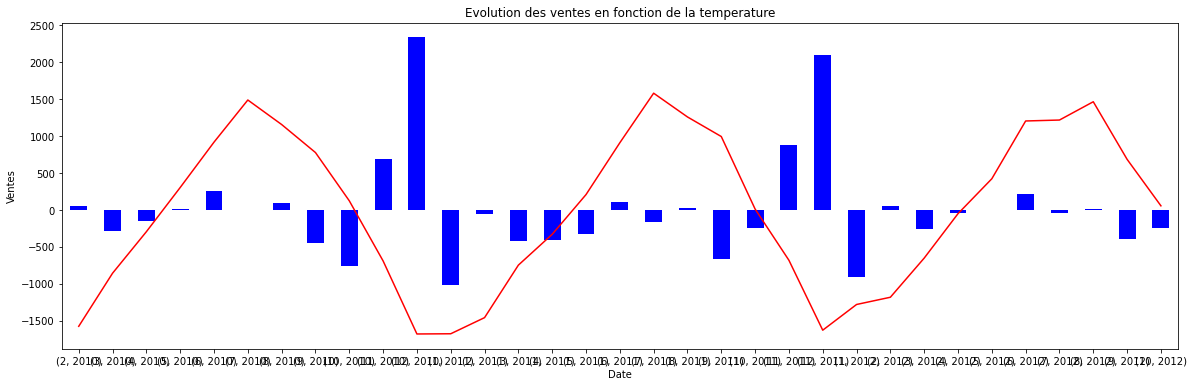

In [83]:
# On regroupe les ventes normalisees par mois et on affiche sur le graphique l'evolution de la temperature
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 6), title="Evolution des ventes en fonction de la temperature", color='blue',ylabel='Ventes')
(new_X['Temperature']/10).groupby(['Month','Year'],sort=False).sum().plot(kind='line',figsize=(20, 6), color='red', xlabel='Date')
plt.show()

Mise en relief du taux de chomage sur les ventes

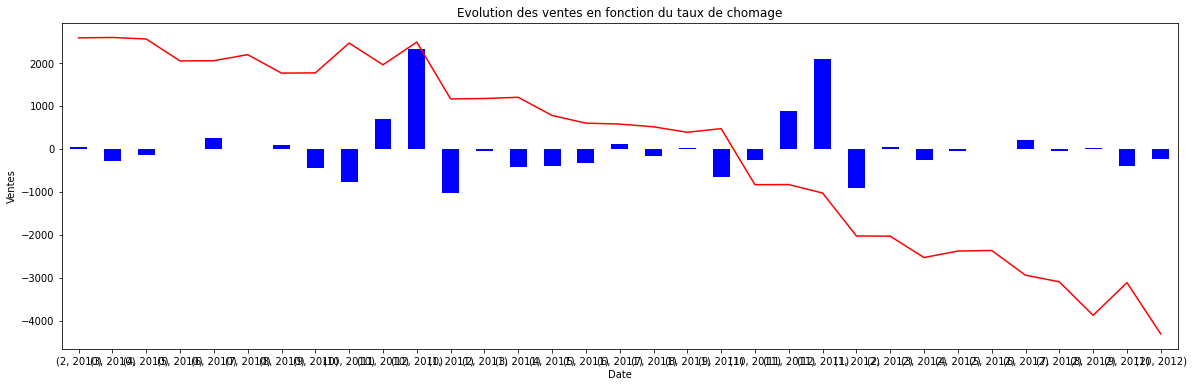

In [88]:
# On regroupe les ventes normalisees par mois et on affiche sur le graphique l'evolution du taux de chomage
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 6), title="Evolution des ventes en fonction du taux de chomage", color='blue',ylabel='Ventes')
(new_X['Unemployment']/1.5).groupby(['Month','Year'],sort=False).sum().plot(kind='line',figsize=(20, 6), color='red', xlabel='Date')
plt.show()

Mise en relief des indicateurs MarkDowns sur les ventes

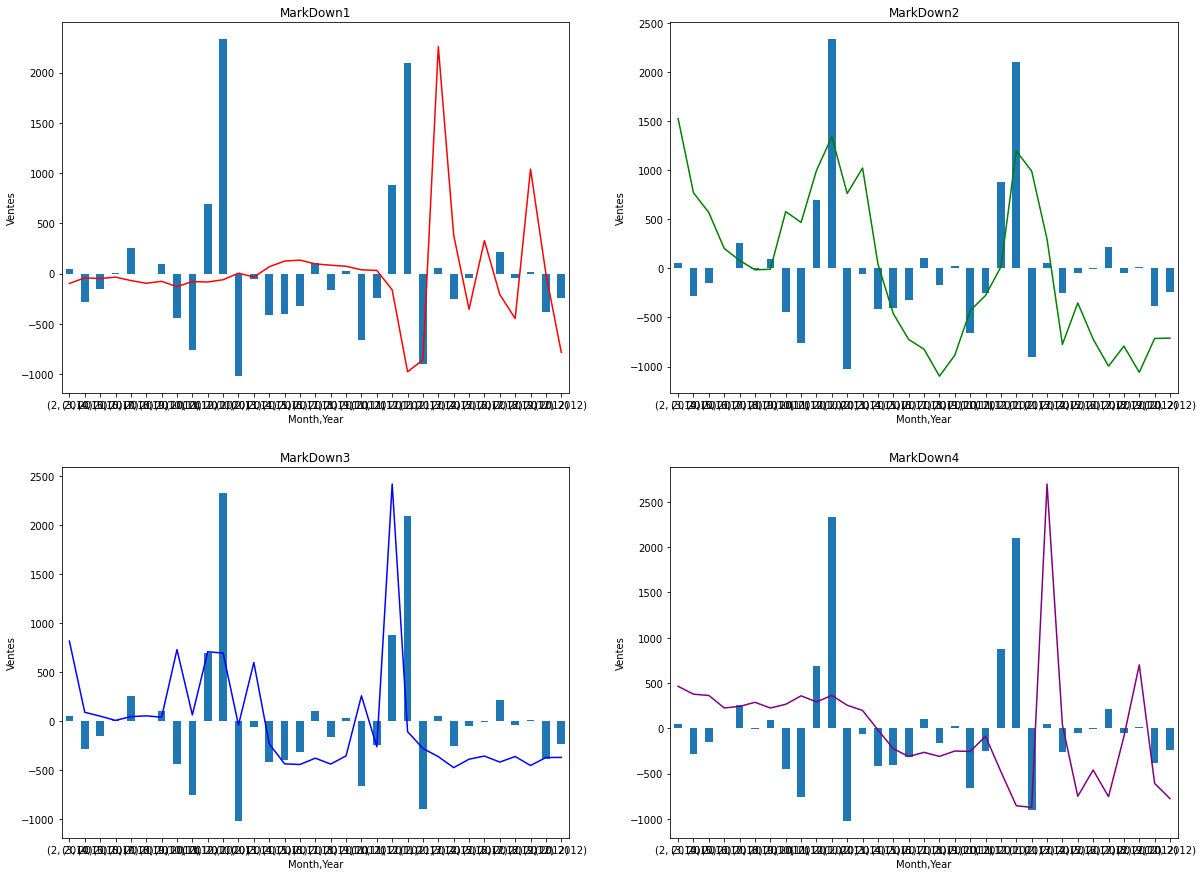

In [103]:
# On regroupe les ventes normalisees par mois et on affiche sur les graphiques les evolutions des indicateurs MarkDowns
plt.subplot(2, 2, 1)
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 15),ylabel='Ventes',title='MarkDown1')
(new_X['MarkDown1'].groupby(['Month','Year'],sort=False).sum()/10).plot(kind='line',figsize=(20, 15), color='red')
plt.subplot(2, 2, 2)
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 15),ylabel='Ventes',title='MarkDown2')
(new_X['MarkDown2'].groupby(['Month','Year'],sort=False).sum()/10).plot(kind='line',figsize=(20, 15), color='green')
plt.subplot(2, 2, 3)
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 15),ylabel='Ventes',title='MarkDown3')
(new_X['MarkDown3'].groupby(['Month','Year'],sort=False).sum()/10).plot(kind='line',figsize=(20, 15), color='blue')
plt.subplot(2, 2, 4)
new_X['Weekly_Sales'].groupby(['Month','Year'],sort=False).sum().plot(kind='bar',figsize=(20, 15),ylabel='Ventes',title='MarkDown4')
(new_X['MarkDown4'].groupby(['Month','Year'],sort=False).sum()/10).plot(kind='line',figsize=(20, 15), color='purple')
plt.show()




Etude des variables size et type sur les ventes

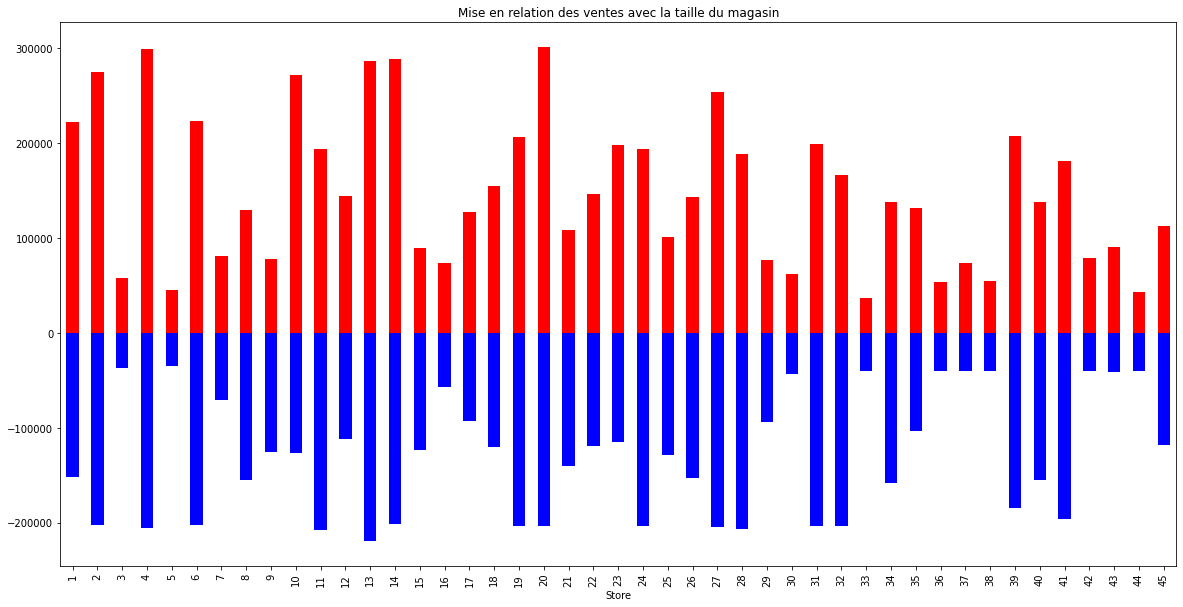

In [158]:
# On regroupe les ventes reelles par magasin (en rouge) et on les met en relation avec la taille de leur magasin (mis en negatif en bleu pour plus de visibilite)
stores['Size'].apply(lambda x:-x).plot(kind='bar',figsize=(20, 10), title='Taille des magasins', color='blue')
(X.groupby('Store').sum()/1000)['Weekly_Sales'].plot(kind='bar',figsize=(20, 10), title='Mise en relation des ventes avec la taille du magasin', color='red')
plt.show()

In [182]:
# Calcul de la correlation entre la taille du magasin et ses ventes globales
var_c = pd.DataFrame({'Sales':X.groupby('Store').sum()['Weekly_Sales'],'Size':stores.groupby('Store')['Size'].apply(lambda x:x).droplevel(1)}).corr()
print("Correlation entre la taille du magasin et les ventes : ",np.round(var_c['Sales']['Size'],3)*100,"%")

Correlation entre la taille du magasin et les ventes :  84.6 %


Visualisation des eventuels clusters entre les magasins

In [203]:
# On prend les donnees initiales des magasins sur leurs ventes , leurs tailles et leurs types et on les normalise
stores_size = pd.DataFrame({'Type':stores.groupby('Store')['Type'].apply(lambda x:x).droplevel(1),'Size':stores.groupby('Store')['Size'].apply(lambda x:x).droplevel(1),'Weekly_Sales':X.groupby('Store').sum()['Weekly_Sales']})
stores_size[['Size','Weekly_Sales']] = StandardScaler().fit_transform(stores_size[['Size','Weekly_Sales']])

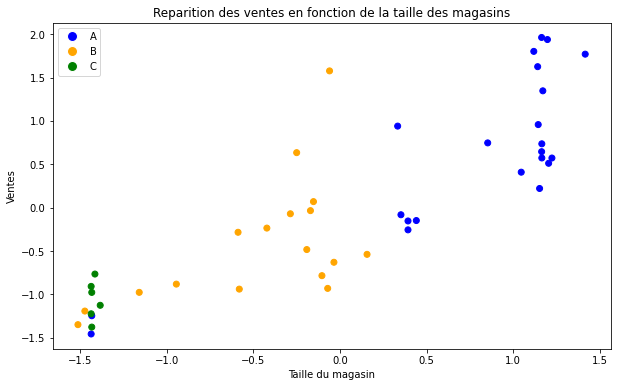

In [242]:
plt.figure(figsize=(10, 6))

type_colors = {'A': 'blue', 'B': 'orange', 'C': 'green'}

plt.scatter(stores_size['Size'], stores_size['Weekly_Sales'], c=stores_size['Type'].map(type_colors))
plt.xlabel('Taille du magasin')
plt.ylabel('Ventes')
plt.title('Reparition des ventes en fonction de la taille des magasins')

legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) for label, color in type_colors.items()]
plt.legend(handles=legend_patches)
plt.show()